In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import json
import torch
import cv2
from typing import Tuple

In [2]:
import torch
import torchvision
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from typing import Optional, List
from collections import defaultdict
from tqdm import tqdm

In [3]:
class MDataset(torch.utils.data.Dataset):
    """Dataset for finding mathematical formulas in scientific documents."""
    
    def __init__(self, 
                 images_folder = Path("../data/processed/image"), 
                 labels_folder = Path("../data/processed/labels"), 
                 transforms: Optional[List] = None):
        self.transforms = []
        
        if transforms is not None:
            self.transforms += transforms
            
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        
        self.label_map = {
            "E": 0,  # "EmbeddedFormula"
            "I": 1,  # "IsolatedFormula"
        }

        self._handles = [
            p.name.replace(".tif", "") 
            for p in self.images_folder.glob("*.tif") 
        ]
        
    def load_data(self):
        """Generator for reading image and labels."""
        for _file in Path(self.labels_folder).glob("*.json"):
            labels = json.loads(_file.read_text())
            handle = _file.name.replace('.json', '')
            image = mpimg.imread(self.images_folder / f"{handle}.tif")

            yield image, labels, handle
    
    def __len__(self):
        """Return the size of the dataset."""
        return len(self._handles)
    
    def __getitem__(self, idx):
        """Return the item on given index."""
        handle = self._handles[idx]

        labels_path = self.labels_folder / f"{handle}.json"
        labels = json.loads(labels_path.read_text())
        
        boxes = torch.tensor([label["rect"] for label in labels])
        labels = torch.tensor([self.label_map[label["type"]] for label in labels])
        
        image = cv2.imread(str(self.images_folder / f"{handle}.tif"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        for transform in self.transforms:
            image = transform(image)
        
        return handle, image.double(), {
            "boxes": boxes.double(), "labels": labels.type(torch.int64)
        }
    
    def from_handle(self, handle):
        """Get data from handle."""
        idx = self._handles.index(handle)
        return self[idx]


In [4]:
dataset = MDataset(transforms=[torchvision.transforms.ToTensor()])

In [5]:
handle, image, labels = dataset[0]
handle

'10.1.1.60.2672_31'

In [6]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:320])
dataset_test = torch.utils.data.Subset(dataset, indices[320:])

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, collate_fn=lambda x:list(zip(*x))
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=True, collate_fn=lambda x:list(zip(*x))
)

handles, images, labels = next(iter(train_loader))

10.1.1.6.2202_3


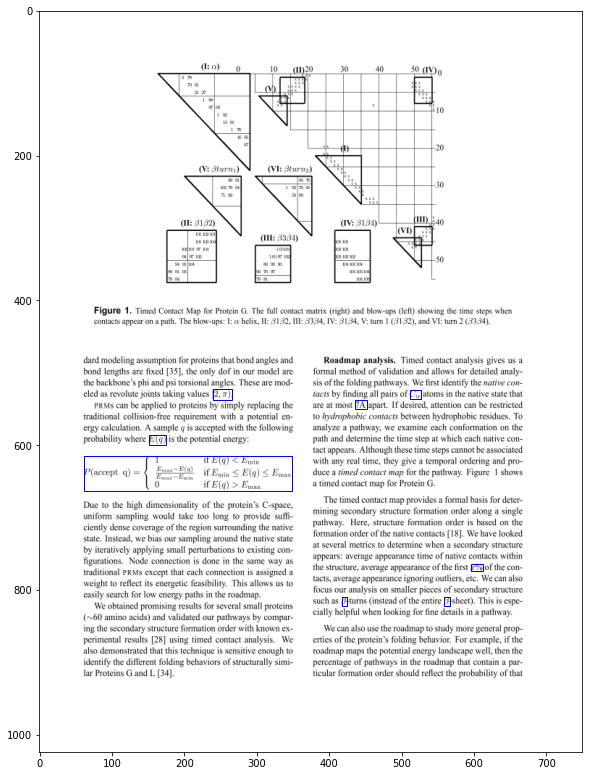

In [7]:
from matplotlib import patches

def view(images, labels, k, std=1, mean=0):
    """Display image with label."""
    figure = plt.figure(figsize=(30, 30))
    for i in range(k):
        out = torchvision.utils.make_grid(images[i])
        inp = out.cpu().numpy().transpose((1, 2, 0))
        inp = np.array(std) * inp + np.array(mean)
        inp = np.clip(inp, 0, 1)
        ax = figure.add_subplot(2, 2, i + 1)
        
        image = images[i].detach().cpu().numpy()
        _image = np.copy(image).transpose(1, 2, 0)
        
        ax.imshow(_image)
        for box in labels[i]["boxes"].detach().cpu().numpy():
            x0, y0, x1, y1 = box
            xy = (x0, y1)
            width = x1 - x0
            height = y0 - y1

            ax.add_patch(patches.Rectangle(xy, width, height, linewidth=1, edgecolor='b', facecolor='none'))


print(handles[0])
handle, image, label = dataset.from_handle("10.1.1.30.3568_9")
# NOTE: check 10.1.1.6.2202_3 => potential problem

#view((image, ), (label, ), 4)
view(images, labels, 1)


In [8]:
# NOTE: If the following cell gives "IProgress" error make sure to 
# pip install -U jupyter ipywidgets
# jupyter nbextension enable --py widgetsnbextension
# and restart

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)
model = model.double()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01)

In [ ]:
model.train()
from tqdm.notebook import tqdm

for epoch in tqdm(range(50)):
    for _, images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [
            {k: v.to(device) for k, v in target.items()}
            for target in targets
        ]
        
        loss = model(images, targets)
        losses = sum(loss for loss in loss.values())
        losses.backward()
        
        optimizer.zero_grad()
        optimizer.step()

    print(f"Loss = {losses.item()}")

torch.save(model.state_dict(), "./faster_rcnn_50e.pth")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load("./faster_rcnn_1e.pth"))

In [ ]:
results = []
model.train(False)
for _, images, targets in tqdm(test_loader):
    images = list(image.to(device) for image in images)
    pred = model(images)
    view(images, pred, 1)
    break